In [612]:
import pandas as pd
import yaml
import numpy as np
import json
import requests
import pdb
import collect_data 
from importlib import reload
from bs4 import BeautifulSoup
from contextlib import suppress
import scholarly
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
sns.set_palette('colorblind')
sns.set_color_codes()
sns.set_context('talk')

In [79]:
reload(collect_data)

<module 'collect_data' from '/Users/forde/Documents/jupyter_docs/r2d_nips/collect_data.py'>

# Collecting Data From the NIPS 2017 Schedule

NIPS 2017 includes canonical links the authors' repository for a given paper.  We use BeautiulSoup to scrape the website's schedule metadata for paper information and the link to the repository.

In [5]:
soup = BeautifulSoup(requests.get("https://nips.cc/Conferences/2017/Schedule").content, 'html5lib')

In [6]:
poster_tables = soup.find_all('div', {'class':'maincard narrower Poster'})

In [7]:
papers = pd.DataFrame(index=range(len(poster_tables)),
                      columns=['title', 'authors', 'paper_url', 'code_url', 'poster_url'])

In [8]:
for p in papers.index:
    title = poster_tables[p].find('div',{'class':'maincardBody'}).contents[0]
    authors = poster_tables[p].find('div',{'class':'maincardFooter'}).contents[0]
    pdf = collect_data.get_url(poster_tables[p], 'Paper')
    repo = collect_data.get_url(poster_tables[p], 'Code')
    poster_pdf = collect_data.get_url(poster_tables[p], 'Poster')
    papers.loc[p] = pd.Series(dict(zip(papers.columns,
                                       [title, authors, pdf, repo, poster_pdf])))

In [9]:
code_papers = papers[papers['code_url'].notnull()]

We also test the urls for GitHub repos by making a request to the listed webpage

In [10]:
code_papers['github'] = code_papers['code_url'].str.contains("github.com")

/Users/forde/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [11]:
code_papers['live'] = [collect_data.test_url(url) for url in code_papers['code_url']]
code_papers['gh_full_path'] = np.logical_and(code_papers['github'], 
                                             code_papers['code_url'].str.rstrip('/')\
                                             .str.split('/').str.len() > 4)

/Users/forde/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/forde/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Some papers are not live at the time of testing, so we extract these and manually review to find the webpage

In [12]:
code_papers[np.logical_or(code_papers['live'] != True, ~code_papers['gh_full_path'])].to_csv('validate_url.csv')

In [13]:
live_gh = code_papers[np.logical_and(code_papers['gh_full_path'], code_papers['live'] == True)]

We collect scraped data on the existence of files in each repo that can be used by repo2docker by inspecting the GitHub page of each repo for the file.  The file types are listed in `file_types`.

GitHub metadata is collected using the GitHub graphql api.  To run this query, one will need to create a [personal access token with GitHub](https://help.github.com/articles/creating-a-personal-access-token-for-the-command-line/).

In [14]:
file_types = ['Dockerfile', 'binder', 'apt.txt', 'environment.yml',
              'requirements.txt', 'postBuild', 'setup.py', 'REQUIRE', 'runtime.txt',
              'install.R']

social_vals = ['description', 'stargazers', 'watchers',
               'forks', 'languages', 'repositoryTopics']

r2d_checks = pd.DataFrame(index=live_gh['code_url'], columns=file_types)
gh_metadata = pd.DataFrame(index=live_gh['code_url'], columns=social_vals)

To recollect data, you will need to replace the line below with your GitHub personal access token

In [545]:
with suppress(Exception):
    credentials = yaml.load(open('../binder_study/secrets.yml'))

For ease of processing, we note URL's that explicitly use the `.git` extension to standardize our data collection.

In [16]:
live_gh['.git'] = live_gh['code_url'].str.split('/').str[4].str[-4:]=='.git'

/Users/forde/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


The block of code below collects all the data from GitHub. Again, this does not run except with a personal access token. Repo2docker file information from this block is saved as `gh_r2d_data.csv`, and GitHub metadata is saved as `gh_metadata.csv`.  Note also we exclude repositories that have changed their URL and include in later analysis.

We have supressed these exceptions to get the notebook to run the whole way through

In [81]:
with suppress(Exception):
    for i in r2d_checks.index:
        split_url = i.split('/')
        if i in live_gh[live_gh['.git']]['code_url'].values:
            soup_i = BeautifulSoup(requests.get(i[:-4]).content, "html5lib")
            gh_metadata.loc[i] = pd.Series(collect_data.graphql_social_data(split_url[3], split_url[4][:-4], credentials['binder']['key']))
        else:
            soup_i = BeautifulSoup(requests.get(i).content, "html5lib")
            gh_metadata.loc[i] = pd.Series(collect_data.graphql_social_data(split_url[3], split_url[4], credentials['binder']['key']))
        r2d_checks.loc[i] = pd.Series(collect_data.request_inspect_for_r2d(i, soup_i, file_types))
    live_gh[live_gh['code_url'].isin(gh_metadata[gh_metadata.isna().all(axis=1)].index.values)]\
    .to_csv('change_reponame.csv')
    gh_metadata = collect_data.process_gh_api_df(gh_metadata.dropna(how='all'))

/Users/forde/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/forde/Documents/jupyter_docs/r2d_nips/collect_data.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['no_code'] = df['n_languages'] == 0
/Users/forde/Documents/jupyter_docs/r2d_nips/collect_data.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

We drop data that does not have any programming languages associated with the repo.

In [547]:
with suppress(Exception):
    gh_metadata[gh_metadata['no_code']].to_csv('no_code.csv')

In [546]:
with suppress(Exception):
    gh_metadata = gh_metadata[~gh_metadata['no_code']]

The csv's below are the results of the original data pull should you want to load the data from here.

In [40]:
try:
    r2d_checks.to_csv('gh_r2d_data.csv')
except:
    r2d_checks = pd.read_csv('gh_r2d_data.csv')

In [47]:
try:
    gh_metadata.to_csv('gh_metadata.csv')
except:
    gh_metadata = gh_metadata.to_csv('gh_metadata.csv')

## Analyzing Manually Annotated Data

For repositories that do not have automatically accessible repositories available, we manually annotate to find the author's URL. Files with these lables are loaded below.

In [86]:
gh_labeled = pd.read_csv('validate_url_w_labels.csv', index_col=0)

In [87]:
changed_url_labeled = pd.read_csv('change_reponame_labeled.csv', index_col=0)

In [88]:
r2d_labeled = pd.DataFrame(index=gh_labeled[gh_labeled['labeled_url'].str[:19] == 'https://github.com/']
                           ['labeled_url'].append(changed_url_labeled['labeled_url']), columns=file_types)

In [544]:
gh_metadata_labeled = pd.DataFrame(index=r2d_labeled, columns=social_vals)

We now collect data for these labeled URLs using the same methodology to find configuration files and GitHub metadata.

In [90]:
with suppress(Exception):
    for i in r2d_labeled.index:
        split_url = i.split('/')
        soup_i = BeautifulSoup(requests.get(i).content, "html5lib")
        r2d_labeled.loc[i] = pd.Series(collect_data.request_inspect_for_r2d(i, soup_i, file_types))
        gh_metadata_labeled.loc[i] = pd.Series(collect_data.graphql_social_data(split_url[3], split_url[4], credentials['binder']['key']))

In [92]:
with suppress(Exception):
    gh_metadata_labeled = collect_data.process_gh_api_df(gh_metadata_labeled)

Labeled and unlabeled datasets are combined below.

In [96]:
with suppress(Exception):
    total_gh_metadata = pd.concat([gh_metadata, gh_metadata_labeled])

In [99]:
with suppress(Exception):
    total_r2d = pd.concat([r2d_checks, r2d_labeled])

In [101]:
try:
    total_gh_metadata.to_csv('gh_metadata_w_labeled.csv')
    total_r2d.to_csv('r2d_w_labeled.csv')
except:
    total_gh_metadata = pd.read_csv('gh_metadata_w_labeled.csv')
    total_r2d = pd.read_csv('r2d_w_labeled.csv')

# Conference Wide Metrics

We calculate the percent of papers that have included any code url, a paper url, and a url to a live GitHub page.

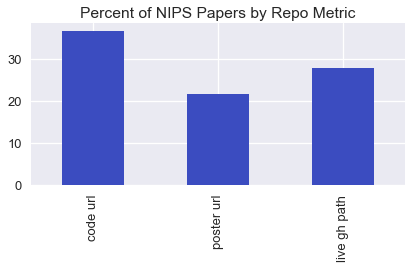

In [580]:
paper_metrics = (len(papers) - papers.isnull().sum()).loc[['code_url','poster_url']]\
.append(live_gh[['gh_full_path']].sum())
paper_metrics.index = ['code url', 'poster url', 'live gh path']
(100.*paper_metrics/len(papers)).plot(kind='bar', cmap='coolwarm')
plt.ylabel('')
plt.xlabel('')
plt.title('Percent of NIPS Papers by Repo Metric')
plt.tight_layout()
plt.savefig('paper_metrics.png')

Below are the raw counts:

In [511]:
paper_metrics

code url             248
poster url           146
live gh repo path    189
dtype: int64

Below are the percentages in the above plot.

In [512]:
(100.*paper_metrics/len(papers))

code url             36.524300
poster url           21.502209
live gh repo path    27.835052
dtype: float64

Programmng

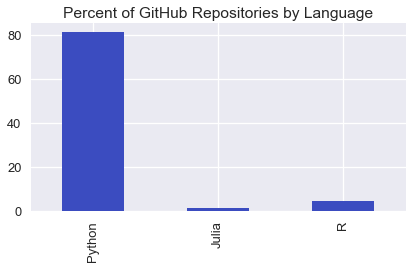

In [560]:
(100*total_gh_metadata[['Python', 'Julia', 'R']].sum()/len(total_gh_metadata)).plot(kind='bar', cmap='coolwarm')
plt.title('Percent of GitHub Repositories by Language')
plt.tight_layout()
plt.savefig('pct_languages.png')

For reference, we also include information on papers that were manually labeled.  A minority of them required manual review.

In [488]:
labeled_url_stats = gh_labeled['labeled_url'].notnull().value_counts()
labeled_url_stats.index = ['found url', 'url still missing']
labeled_url_stats.loc['missing_https'] = gh_labeled['missing_https'].sum()
labeled_url_stats.loc['changed_url'] = len(changed_url_labeled)
labeled_url_stats.index = ['found url', 'url still missing', 'missing https', 'changed url']

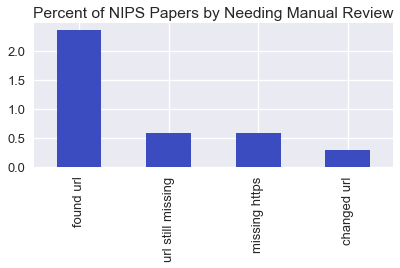

In [563]:
(100.*labeled_url_stats/len(papers)).plot(kind='bar',  cmap='coolwarm')
plt.ylabel('')
plt.xlabel('')
plt.title('Percent of NIPS Papers by Needing Manual Review')
plt.tight_layout()
plt.savefig('manual_review_metrics.png')

In [510]:
len(papers)

679

In [511]:
paper_metrics

code url             248
poster url           146
live gh repo path    189
dtype: int64

In [512]:
(100.*paper_metrics/len(papers))

code url             36.524300
poster url           21.502209
live gh repo path    27.835052
dtype: float64

# Reproducing Reults Figures

Below are figures from the submission.  This figure shows the number of repositories using each type of repo2docker config file.

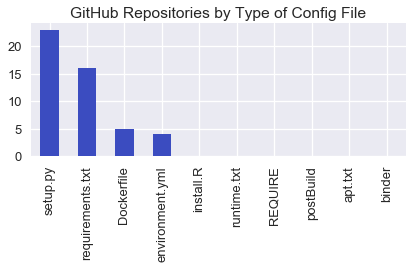

In [565]:
total_r2d.sum().sort_values(ascending=False).plot(kind='bar', colormap='coolwarm')
plt.title('GitHub Repositories by Type of Config File')
plt.ylabel('')
plt.tight_layout()
plt.savefig('repos_by_r2d_file.png')

Below are the raw values:

In [534]:
total_r2d.sum().sort_values(ascending=False)

setup.py            23
requirements.txt    16
Dockerfile           5
environment.yml      4
install.R            0
runtime.txt          0
REQUIRE              0
postBuild            0
apt.txt              0
binder               0
dtype: int64

Below are the number of repositories that have 0, 1, 2, or 3 configuration files:

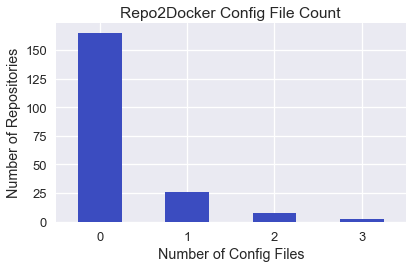

In [566]:
total_r2d.sum(axis=1).value_counts().plot(kind='bar', colormap='coolwarm', rot=0)
plt.xlabel('Number of Config Files')
plt.ylabel('Number of Repositories')
plt.title('Repo2Docker Config File Count')
plt.tight_layout()
plt.savefig('total_r2d_files_plot.png')

The raw values of the plot above are below

In [535]:
total_r2d.sum(axis=1).value_counts()

0    165
1     26
2      8
3      2
dtype: int64

We now label repositories that are repo2docker compatible as repositories that have at least 1 type of configuration file that repo2docker uses.

In [167]:
total_gh_metadata['r2d_capable'] = total_r2d.sum(axis=1) > 0

The average number of users that have forked, starred, or watched is significantly higher when we exclude repositories that are part of larger libraries.  We label larger libraries as libraries that point to a specific folder in the repo as the code, rather than the main repository URL.  These libraries are part of larger deep learning repos.

In [548]:
total_gh_metadata['larger_library'] = total_gh_metadata.index.str.rstrip('/').str.split('/').str.len() > 5
main_repo = total_gh_metadata[~total_gh_metadata['larger_library']]
wo_larger_test = ttest_ind(main_repo[main_repo['r2d_capable']][['forks', 'stargazers', 'watchers']],
          main_repo[~main_repo['r2d_capable']][['forks', 'stargazers', 'watchers']])

In [551]:
larger_libraries = total_gh_metadata[total_gh_metadata['larger_library']]
larger_libraries.to_csv('larger_libraries.csv')
w_larger_test = ttest_ind(total_gh_metadata[total_gh_metadata['r2d_capable']][['forks', 'stargazers', 'watchers']],
          total_gh_metadata[~total_gh_metadata['r2d_capable']][['forks', 'stargazers', 'watchers']])

In [554]:
larger_libraries

,description,stargazers,watchers,forks,languages,repositoryTopics,n_languages,no_code,primary_language,Python,Julia,R,r2d_capable,larger_library
https://github.com/neulab/dynet-benchmark/tree/autobatch,Benchmarks for DyNet,53,14,12,"[Python, C++, Shell, Makefile]",[],4,False,Python,True,False,False,False,True
https://github.com/tensorflow/models/tree/master/research/pcl_rl,Models and examples built with TensorFlow,36531,2400,19633,"[Python, Jupyter Notebook, C++, HTML, Shell, J...",[],8,False,Python,True,False,False,False,True
https://github.com/tensorflow/models/tree/master/research/rebar,Models and examples built with TensorFlow,36531,2400,19633,"[Python, Jupyter Notebook, C++, HTML, Shell, J...",[],8,False,Python,True,False,False,False,True


The figure below shows that the p-values of our t-tests drops to less than 0.05 when we exclude larger libraries.  Results are not statistically signifacant when larger libraries are included.

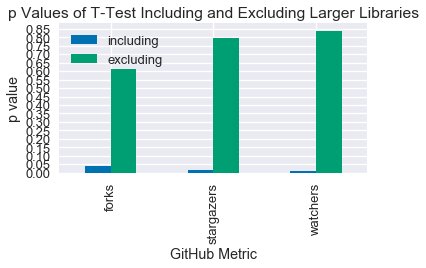

In [569]:
pd.DataFrame([wo_larger_test.pvalue, w_larger_test.pvalue], index=['including', 'excluding'],
            columns=['forks', 'stargazers', 'watchers']).T.plot(kind='bar', yticks=np.arange(0,.86,0.05))
plt.ylabel('p value')
plt.title('p Values of T-Test Including and Excluding Larger Libraries')
plt.xlabel('GitHub Metric')
plt.legend(loc=2)
plt.tight_layout()
plt.savefig('p_values.png')

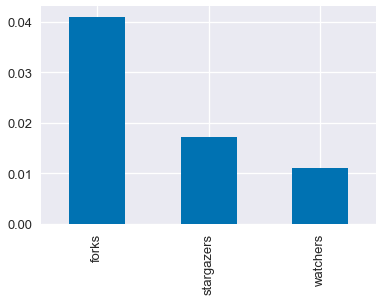

In [586]:
ax = pd.DataFrame(wo_larger_test.pvalue, index=['forks', 'stargazers', 'watchers']).plot(kind='bar')
ax.legend_.remove()
plt.title('p-values of ')

Below are the p-values for forks, stargazers, and watchers when larger repositories are excluded

In [543]:
wo_larger_test.pvalue

array([0.04106162, 0.01712506, 0.01100394])

We also plot the means with errorbars when including and excluding larger libraries

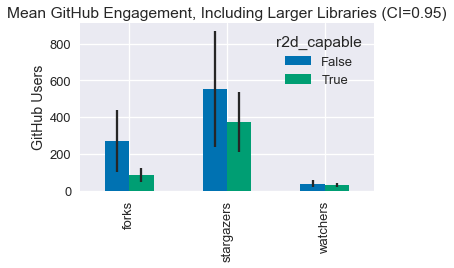

In [570]:
total_gh_metadata.groupby(['r2d_capable'])[['forks', 'stargazers', 'watchers']].mean()\
.T.plot(kind='bar', yerr=.975*total_gh_metadata.groupby(['r2d_capable'])[['stargazers', 'watchers',  'forks']].sem().T)
plt.xlabel('')
plt.ylabel('GitHub Users')
plt.title('Mean GitHub Engagement, Including Larger Libraries (CI=0.95)')
plt.tight_layout()
plt.savefig('engagement_incl_lrg.png')

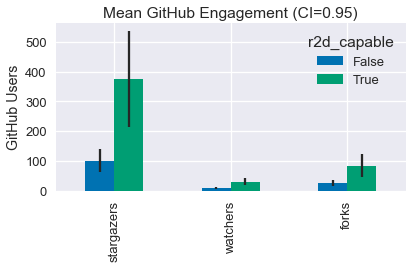

In [607]:
total_gh_metadata[~total_gh_metadata['larger_library']].groupby(['r2d_capable'])[['stargazers', 'watchers',  'forks']].mean()\
.T.plot(kind='bar', yerr=.975*total_gh_metadata[~total_gh_metadata['larger_library']]\
        .groupby(['r2d_capable'])[['stargazers', 'watchers',  'forks']].sem().T)
plt.xlabel('')
plt.ylabel('GitHub Users')
plt.title('Mean GitHub Engagement (CI=0.95)')
plt.tight_layout()
plt.savefig('engagement_excl_lrg.png')

The jittered factorplot below shows the effect of these unusually popular libraries on the distributions of forks, stargazers, and watchers.

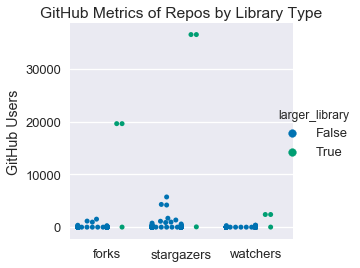

In [606]:
ax = sns.factorplot(x="GitHub Metric", y="GitHub Users", hue="larger_library",
                    data=melted, dodge=True, kind="swarm", size=4)
plt.xlabel('')
plt.title('GitHub Metrics of Repos by Library Type')
plt.tight_layout()
plt.savefig('gh_metrics_library_type.png')

For simplicity, we also plot a boxplot to highlight these outliers.

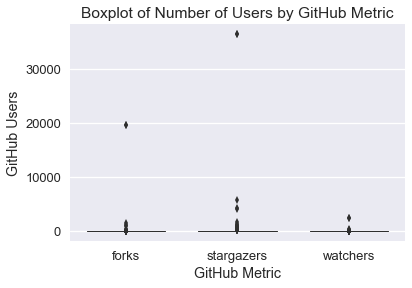

In [598]:
sns.boxplot(x="GitHub Metric", y="GitHub Users", data=melted, linewidth=1, width=0.7, fliersize=5)
plt.title('Boxplot of Number of Users by GitHub Metric')
plt.savefig('gh_metrics_boxplot.png')

In [514]:
len(total_gh_metadata)

197

In [515]:
197-189

8

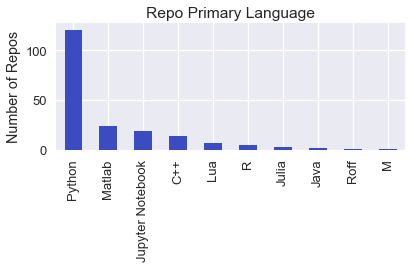

In [614]:
total_gh_metadata['primary_language'].value_counts().plot(kind='bar', cmap='coolwarm')
plt.title('Repo Primary Language')
plt.ylabel('Number of Repos')
plt.tight_layout()
plt.savefig('primary_language.png')